In [11]:
import os
import numpy as np
import keras
from keras.applications import inception_v3
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from collections import Counter
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline
from sklearn.metrics import silhouette_score
from pylab import rcParams
rcParams["font.size"] = 14

print 'Notebook run using keras:', keras.__version__

Notebook run using keras: 2.1.6


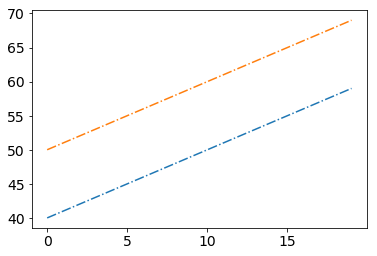

In [25]:
plt.plot(range(20), range(40,60), range(50, 70), linestyle="-.")

In [2]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image, grid_segmentation, evaluation_measures, helper_functions, clustering

In [3]:
sys.path.append('../../lime')
import clustering

In [4]:
path_of_imgs = sorted( helper_functions.absoluteFilePaths('../../../chosen_1000_images_resized') )

In [5]:
images = clustering.load_images(path_of_imgs)

In [9]:
df = pd.read_csv("../../../predizioni_bb.txt", " ")
real_classes = df["class_name"]

## Evaluate Spectral Clustering for different downsapling sizes and K

In [8]:
undersample_sizes = [4,8,16,32,64]
range_of_ks = range(2,101)

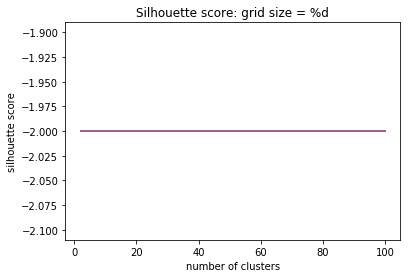

In [9]:
for j in range(len(undersample_sizes)):
    # Undersample images
    und = clustering.undersample_images(images, undersample_sizes[j])
    flattened = clustering.flatten_images(und)
    
    silhouettes = []
    
    for cl in range_of_ks:
        try:
            labels = SpectralClustering(n_clusters=cl, n_jobs=-1).fit_predict(flattened)
            silhouettes.append(silhouette_score(flattened, labels))
        except:
            silhouettes.append(-2)
    del und
    del flattened
    
    # now sihlouettes contains, for each k, the silhouette value.
    # remember that the grid size is fixed
    
    plt.title("Silhouette score: grid size = %d")
    plt.ylabel("silhouette score")
    plt.xlabel("number of clusters")
    plt.plot(range_of_ks, silhouettes)
    

In [6]:
und = clustering.undersample_images(images, 8)


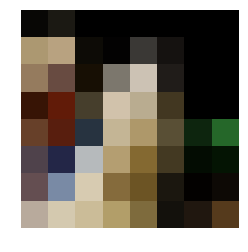

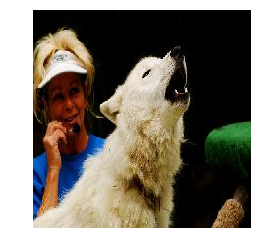

In [20]:
index = 3
plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(und[index])
plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(images[index])

## Evaluate K-means for different downsapling sizes and different K

In [7]:
undersample_sizes = [4,8,16,32,64]
range_of_ks = range(2,101)

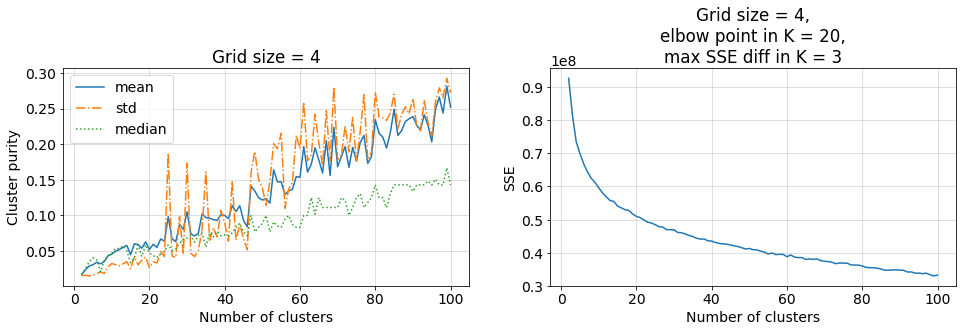

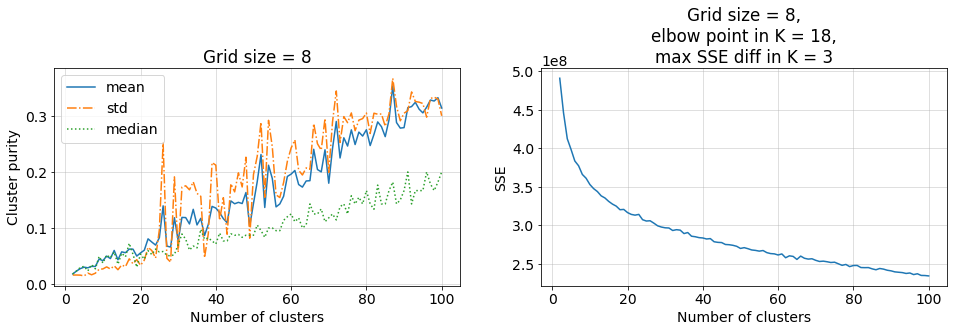

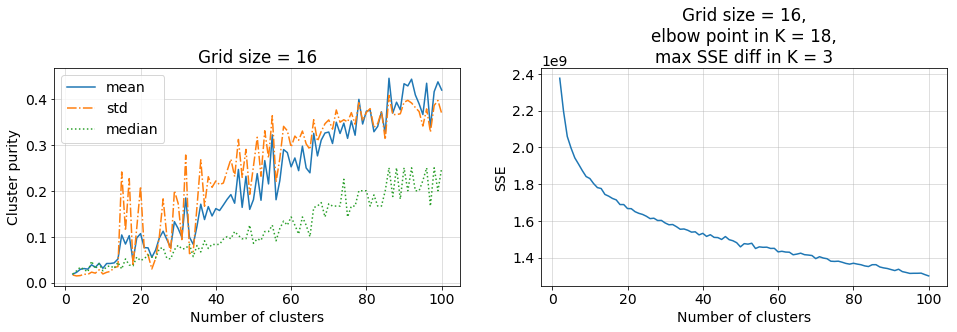

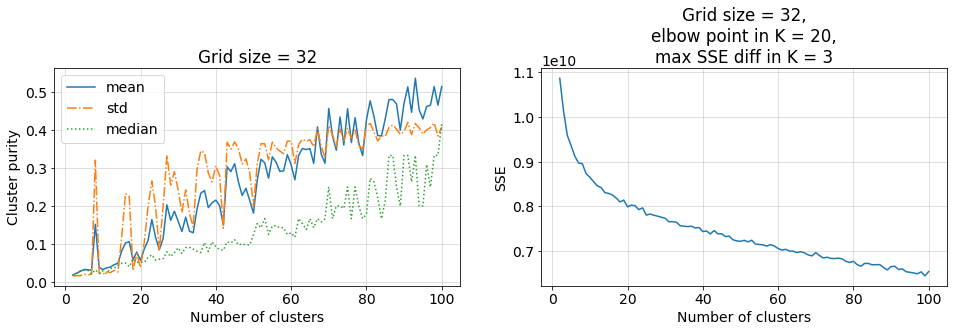

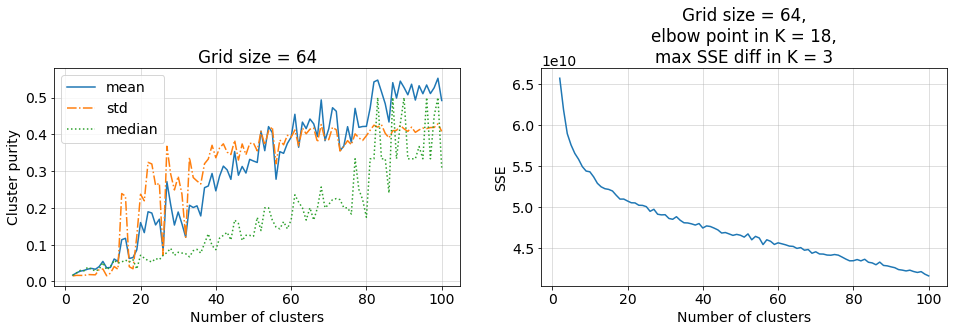

CPU times: user 13min 39s, sys: 1min 11s, total: 14min 51s
Wall time: 31min 36s


In [28]:
%%time
for j in range(len(undersample_sizes)):
    # Undersample images
    und = clustering.undersample_images(images, undersample_sizes[j])
    flattened = clustering.flatten_images(und)

    # Apply K-means to the downsampled images, for different K's
    global_results = []
    sse_list = []
    for k in range_of_ks:    
        compactness, labels, centers = clustering.k_means(flattened, k)

        cluster_scores = []
        for cluster in range(k):#chosen_clusters:
            clus_classes = [real_classes[i] for i in range(len(images)) if labels[i] == cluster]
            occurrences_of_each_class = Counter(clus_classes)
            top_class = max(occurrences_of_each_class)
            occs = occurrences_of_each_class[top_class]
            cluster_scores.append((float(occs) / len(clus_classes)))

        global_results.append((np.mean(cluster_scores), np.std(cluster_scores), np.median(cluster_scores)))
        sse_list.append(compactness)

    del und
    
    # Plot the quality of the clustering (cluster purity and SSE, side by side)
    plt.figure(figsize=(16,4))
    
    global_results = np.array(global_results)
    
    # Cluster purity
    plt.subplot2grid((1,2), (0,0))
    plt.plot(range_of_ks, global_results[:,0])
    plt.plot(range_of_ks, global_results[:,1], linestyle="-.")
    plt.plot(range_of_ks, global_results[:,2], linestyle=":")
    plt.legend(["mean", "std", "median"])
    plt.grid(alpha=0.5)
    plt.title("Grid size = %s" % undersample_sizes[j])
    plt.xlabel("Number of clusters")
    plt.ylabel("Cluster purity")
    
    # SSE 
    
    # TODO: add knee point value and max_diff
    
    best_k_index = clustering.get_knee_point_value(sse_list)
    diffs = [0] * len(sse_list)
    for i in range(1, len(sse_list)):
        diffs[i] = abs(sse_list[i] - sse_list[i-1])
    max_diff = max(diffs)
    index_of_max_SSE_diff = diffs.index(max_diff)
    
    
    plt.subplot2grid((1,2), (0,1))
    plt.plot(range_of_ks, sse_list)
    plt.grid(alpha=0.5)
    plt.title("Grid size = %s,\nelbow point in K = %s,\nmax SSE diff in K = %s" % (undersample_sizes[j], range_of_ks[best_k_index], range_of_ks[index_of_max_SSE_diff]))
    plt.ylabel("SSE")
    plt.xlabel("Number of clusters")
    
    plt.show()